# Assignment4 - Question 1  (Alejandro Akifarry - 301-195-788)
---

## Imports

In [187]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import random
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from scipy.stats import mode
from sklearn.mixture import GaussianMixture
from scipy.ndimage import rotate

---

## 1. Retrieve and load the Olivetti faces dataset

In [86]:
olivetti_faces = fetch_olivetti_faces()
X = olivetti_faces.data
y = olivetti_faces.target
images = olivetti_faces.images # 64x64 version of .data
print(X.shape)
print(y.shape)

(400, 4096)
(400,)


---

## 2. Split the dataset into training, validation, and test sets using stratified sampling to ensure that each set contains the same number of images per person.

In [87]:
'''
Split is:
80% train
10% validation
10% test
to ensure we have a lot of data to train, 
and also still have some left for validation and testing
'''
# First split into train + validation (90%) and test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)

# Now split the train + validation set (90%) into train (80%) and validation (10%)
# 10/90 = 0.1111
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42, stratify=y_train_val)

In [88]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(320, 4096)
(40, 4096)
(40, 4096)
(320,)
(40,)
(40,)


---

## 3. Apply PCA on the training data, preserving 99% of the variance, to reduce the dataset’s dimensionality. 

In [89]:
pca = PCA(n_components=0.99)

X_train_reduced = pca.fit_transform(X_train)

In [90]:
print(X_train_reduced.shape)
print(y_train.shape)

(320, 222)
(320,)


---

## 4. Determine the most suitable covariance type for the dataset.

In [50]:
covariance_types = ["spherical", "diag", "tied", "full"]

aic_scores_4 = []
bic_scores_4 = []
n_components = 35
n_inits = 10

for c_type in covariance_types:
    gm = GaussianMixture(
        n_components=n_components,
        covariance_type=c_type,
        n_init=n_inits,
        random_state=42)
    gm.fit(X_train_reduced)

    # Get scores
    aic = gm.aic(X_train_reduced)
    bic = gm.bic(X_train_reduced)

    # Collect scores
    aic_scores_4.append(aic)
    bic_scores_4.append(bic)

    print(f"Covariance type: {c_type}; AIC: {aic}; BIC: {bic}")

# Find the best covariance type
best_cov_aic = covariance_types[aic_scores_4.index(min(aic_scores_4))]
best_cov_bic = covariance_types[bic_scores_4.index(min(bic_scores_4))]

print(f"Best covariance type by AIC: {best_cov_aic}")
print(f"Best covariance type by BIC: {best_cov_bic}")

Covariance type: spherical; AIC: 72591.38641849092; BIC: 102131.2547045183
Covariance type: diag; AIC: 18950.900833100663; BIC: 77638.73202159286
Covariance type: tied; AIC: 46890.859420667446; BIC: 169576.08608072528
Covariance type: full; AIC: 947071.9868220057; BIC: 4241183.700184093
Best covariance type by AIC: diag
Best covariance type by BIC: diag


---

## 5. Determine the minimum number of clusters that best represent the dataset using either AIC or BIC. 

In [51]:
covariance_type = "diag"
n_components_range = range(1, 31)
n_inits = 10
aic_scores_5 = []
bic_scores_5 = []

for i in n_components_range:
    gm = GaussianMixture(
        n_components=i,
        covariance_type=covariance_type,
        n_init=n_inits,
        random_state=42)
    gm.fit(X_train_reduced)

    # Get scores
    aic = gm.aic(X_train_reduced)
    bic = gm.bic(X_train_reduced)

    # Collect scores
    aic_scores_5.append(aic)
    bic_scores_5.append(bic)

    print(f"# of cluster: {i}; AIC: {aic}; BIC: {bic}")

# Find the best number of cluster
best_n_aic = n_components_range[aic_scores_5.index(min(aic_scores_5))]
best_n_bic = n_components_range[bic_scores_5.index(min(bic_scores_5))]

print(f"Best # of clusters by AIC: {best_n_aic}")
print(f"Best # of clusters by BIC: {best_n_bic}")

# of cluster: 1; AIC: 16442.472390572664; BIC: 18115.606912705098
# of cluster: 2; AIC: 14650.75949682529; BIC: 18000.796862085954
# of cluster: 3; AIC: 14340.22276843553; BIC: 19367.16297682442
# of cluster: 4; AIC: 14768.83880564405; BIC: 21472.681857161173
# of cluster: 5; AIC: 14813.145032443414; BIC: 23193.89092708876
# of cluster: 6; AIC: 15425.5876472313; BIC: 25483.23638500488
# of cluster: 7; AIC: 15656.843033303801; BIC: 27391.39461420561
# of cluster: 8; AIC: 15974.696099897166; BIC: 29386.1505239272
# of cluster: 9; AIC: 16351.891886554706; BIC: 31440.249153712968
# of cluster: 10; AIC: 16256.175629226498; BIC: 33021.43573951299
# of cluster: 11; AIC: 17309.97875502138; BIC: 35752.1417084361
# of cluster: 12; AIC: 17516.2595375869; BIC: 37635.32533412985
# of cluster: 13; AIC: 17349.353600438342; BIC: 39145.32224010952
# of cluster: 14; AIC: 17941.195266859504; BIC: 41414.06674965891
# of cluster: 15; AIC: 18601.12795074337; BIC: 43750.902276671
# of cluster: 16; AIC: 18218

---

## 6. Plot the results from steps 3, 4 and 5.

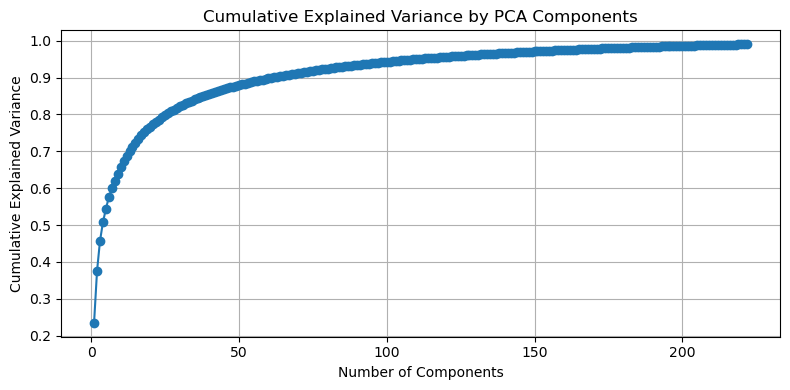

In [97]:
# Step 3 results
cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)

plt.tight_layout()
plt.show()

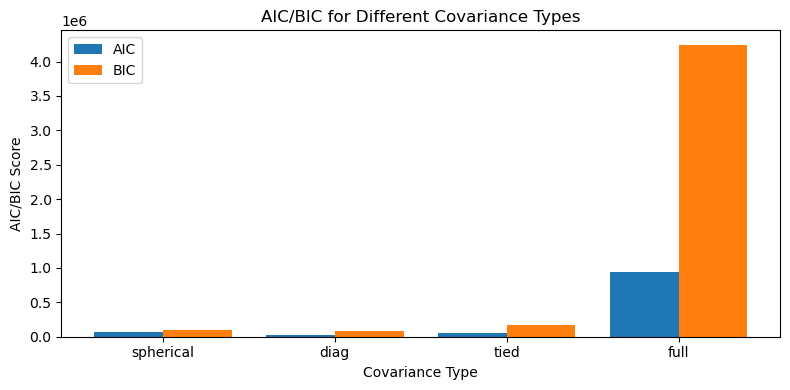

In [98]:
# Step 4 results
plt.figure(figsize=(8, 4))

x_axis_4 = np.arange(len(covariance_types))
plt.bar(x_axis_4 - 0.2, aic_scores_4, 0.4, label="AIC")
plt.bar(x_axis_4 + 0.2, bic_scores_4, 0.4, label="BIC")
plt.xticks(x_axis_4, covariance_types)
plt.xlabel('Covariance Type')
plt.ylabel('AIC/BIC Score')
plt.title('AIC/BIC for Different Covariance Types')
plt.legend()

plt.tight_layout()
plt.show()

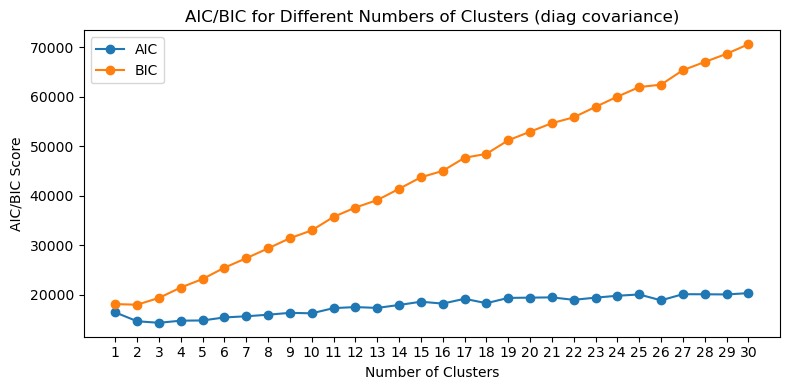

In [99]:
# Step 5 results
plt.figure(figsize=(8, 4))

plt.plot(n_components_range, aic_scores_5, label='AIC', marker='o')
plt.plot(n_components_range, bic_scores_5, label='BIC', marker='o')
plt.xticks(n_components_range)
plt.xlabel('Number of Clusters')
plt.ylabel('AIC/BIC Score')
plt.title(f'AIC/BIC for Different Numbers of Clusters (diag covariance)')
plt.legend()

plt.tight_layout()
plt.show()

---

## 7. Output the hard clustering assignments for each instance to identify which cluster each image belongs to.

In [100]:
# Using parameters from above
n_components = 3
covariance_type = "diag"
n_inits = 10

gm = GaussianMixture(
    n_components=n_components,
    covariance_type=covariance_type,
    n_init=n_inits,
    random_state=42)
gm.fit(X_train_reduced)

y_train_hard = gm.predict(X_train_reduced)
print(y_train_hard)

[1 0 0 0 1 2 0 2 2 2 1 0 2 2 0 1 2 2 2 0 2 2 0 2 2 0 0 1 2 1 1 2 0 0 2 0 0
 2 1 1 1 2 0 2 1 2 0 1 1 2 1 2 2 2 0 2 2 2 0 1 2 1 2 2 1 2 1 2 2 0 0 1 1 0
 2 2 2 2 1 2 2 1 0 2 2 2 1 0 2 1 1 0 2 1 2 0 2 2 0 1 1 1 2 1 2 2 0 1 0 0 2
 0 0 0 0 1 2 0 1 2 1 1 1 2 0 2 1 0 1 1 2 1 1 0 0 0 0 0 1 1 2 2 2 1 2 2 1 2
 2 2 1 2 2 1 2 2 0 0 2 1 0 2 0 0 1 2 0 2 1 2 1 0 0 1 2 2 2 2 1 0 0 2 0 2 1
 0 1 1 0 0 0 2 2 2 1 0 0 2 2 1 0 2 2 1 1 1 0 2 2 2 2 0 1 0 2 0 1 2 2 2 2 1
 0 1 2 2 2 0 2 2 1 2 0 1 2 0 0 0 0 2 0 1 2 0 2 0 2 2 0 2 1 1 1 0 1 1 2 0 1
 1 2 1 0 0 2 0 1 2 0 0 1 0 1 2 0 0 0 2 0 2 0 0 2 2 0 0 1 2 2 2 2 1 1 0 1 2
 0 0 0 1 2 0 2 0 0 2 0 0 2 0 1 0 2 0 1 2 0 0 2 2]


In [82]:
y_train_hard.shape

(320,)

---

## 8. Output the soft clustering probabilities for each instance to show the likelihood of each image belonging to each cluster.

In [103]:
soft_clustering_probabilities = gm.predict_proba(X_train_reduced)

# 3 columns, each column is the likelihood of the image being in a cluster
print(soft_clustering_probabilities)

[[1.52123005e-17 9.99525175e-01 4.74825067e-04]
 [1.00000000e+00 1.13766565e-15 1.70718590e-10]
 [9.99981422e-01 1.12526630e-13 1.85779935e-05]
 [1.00000000e+00 4.35533434e-17 7.38450048e-11]
 [9.88397258e-28 1.00000000e+00 8.70066113e-12]
 [9.46024111e-05 2.82030408e-14 9.99905398e-01]
 [9.91458153e-01 1.16176918e-14 8.54184688e-03]
 [5.89537932e-05 6.79282460e-06 9.99934253e-01]
 [2.63228507e-08 1.22281971e-11 9.99999974e-01]
 [1.52307344e-10 4.65055340e-04 9.99534945e-01]
 [5.30646393e-25 9.99999719e-01 2.80982376e-07]
 [9.99995372e-01 5.07112788e-14 4.62765419e-06]
 [6.78846535e-09 1.30826175e-07 9.99999862e-01]
 [5.15255268e-17 6.61222360e-03 9.93387776e-01]
 [1.00000000e+00 2.47833649e-19 1.62924816e-12]
 [1.47243417e-29 1.00000000e+00 4.94746560e-13]
 [2.66749346e-12 2.28968044e-06 9.99997710e-01]
 [1.08535019e-17 7.25044676e-09 9.99999993e-01]
 [1.02568750e-11 1.20005296e-03 9.98799947e-01]
 [9.99646353e-01 2.45886615e-07 3.53401059e-04]
 [6.67954894e-12 7.88041898e-06 9.999921

In [105]:
soft_clustering_probabilities.shape

(320, 3)

---

## 9. Use the model to generate some new faces (using the sample() method) and visualize them (use the inverse_transform() method to transform the data back to its original space based on the PCA method used).

In [109]:
X_new_reduced, y_new_reduced = gm.sample(5)
print("Generated new points:\n", X_new)
print("Generated new labels:\n", y_new)

Generated new points:
 [[ 2.82016503e+00  4.01447105e+00 -1.64153586e-01 ... -2.40156119e-01
   9.51402487e-02 -1.76584636e-01]
 [-1.01369584e+00  4.05302503e+00 -3.71643755e-01 ...  1.00270476e-03
  -1.28186798e-01  5.37171133e-02]
 [ 1.98060752e+00 -3.51034081e+00 -1.86171378e+00 ...  1.63736640e-02
  -3.21157742e-02  1.23193892e-01]
 [-8.79481248e+00  4.06255461e+00  2.67424710e+00 ... -2.02337969e-02
   4.52937866e-02  9.02767618e-02]
 [ 3.35481434e+00  1.98077982e+00  2.93111023e+00 ...  2.71888284e-01
  -2.75133395e-02  2.85336082e-02]]
Generated new labels:
 [0 1 1 1 2]


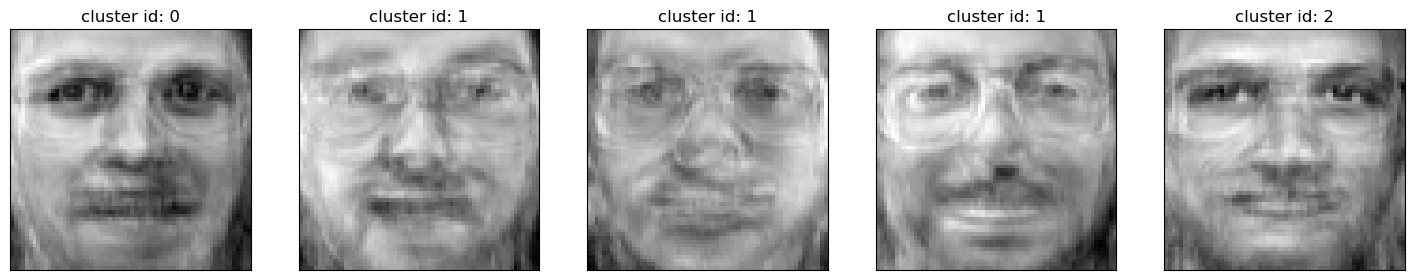

In [117]:
X_new_original = pca.inverse_transform(X_new_reduced)

fig, axarr = plt.subplots(nrows=1, ncols=5, figsize=(18,9))
axarr = axarr.flatten()
for i in range(5):
    axarr[i].imshow(X_new_original[i].reshape(64, 64), cmap='gray')
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title(f"cluster id: {y_new_reduced[i]}")

---

## 10. Modify some images (e.g., rotate, flip, darken).

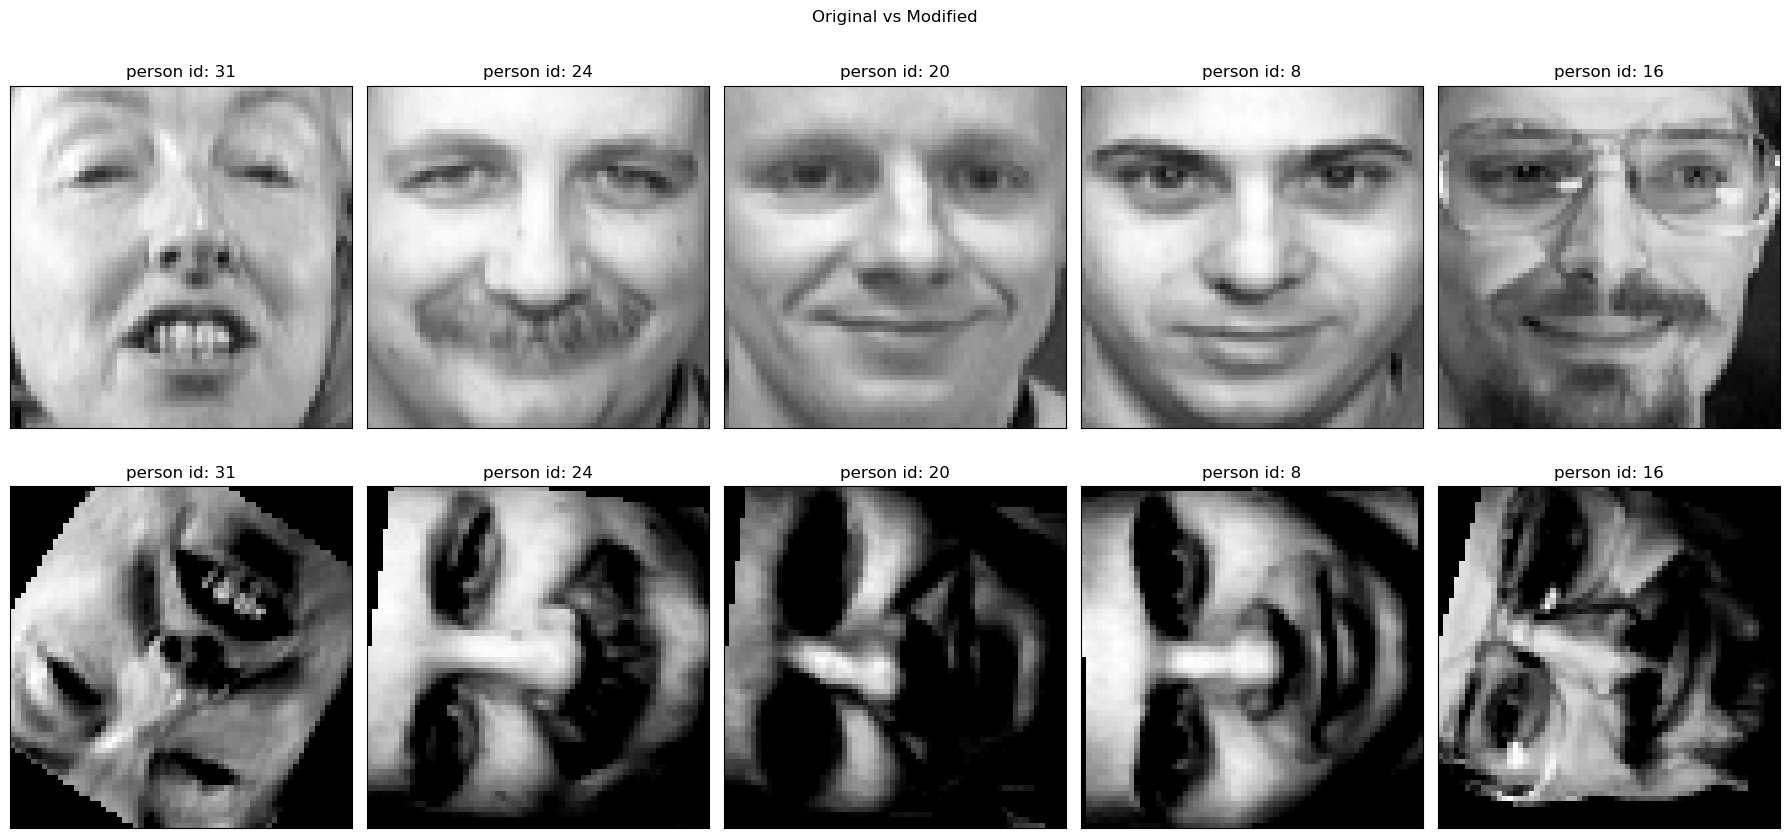

In [194]:
X_modified = []

for i in range(5):
    original_image = X_train[i].reshape(64, 64)

    # Rotate image
    modified_image = rotate(original_image, angle=random.randint(30, 150), reshape=False)

    # Flip vertically
    modified_image = np.flip(modified_image, axis=0)

    # Darken
    modified_image = modified_image - 0.45

    # Ensure values are still between 0 and 1
    modified_image = np.clip(modified_image, 0, 1)

    X_modified.append(modified_image)

fig, axarr = plt.subplots(nrows=2, ncols=5, figsize=(18,9))
axarr = axarr.flatten()
for i in range(5):
    axarr[i].imshow(X_train[i].reshape(64, 64), cmap='gray')
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title(f"person id: {y_train[i]}")
for i in range(5, 10):
    axarr[i].imshow(X_modified[i-5], cmap='gray')
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title(f"person id: {y_train[i-5]}")
plt.suptitle("Original vs Modified")
plt.tight_layout()
plt.show()

---

## 11. Determine if the model can detect the anomalies produced in step 10 by comparing the output of the score_samples() method for normal images and for anomalies.

In [214]:
# Initialize variables
X_normals = X_train[:5]
X_anomalies = np.array(X_modified).reshape((5, 4096))
print(X_normals.shape)
print(X_anomalies.shape)

(5, 4096)
(5, 4096)


In [217]:
# Apply PCA so it fits the model
X_normals_reduced = pca.transform(X_normals)
X_anomalies_reduced = pca.transform(X_anomalies)
print(X_normals_reduced.shape)
print(X_anomalies_reduced.shape)

(5, 222)
(5, 222)


In [219]:
normal_scores = gm.score_samples(X_normals_reduced)
anomaly_scores = gm.score_samples(X_anomalies_reduced)

In [220]:
normal_scores

array([-54.25094393,  45.47143443,   6.51136004,  45.39336291,
       -48.89316463])

In [221]:
anomaly_scores

array([-182.93694333, -115.8220875 ,  -81.81965375, -136.55983281,
       -159.18618757])

seems to be able to detect the anomalies. the scores of the modified images are much lower compared to the images that are unmodified.

---